# Introduction

In my final effort to debug the mesh solve that uses first derivatives for the monitor funciton, I turn to the 1D analog of my 2D Madden problem.
In particular, in this notebook I solve the Nonlinear Winslow Problem in 1D and interpolate the $(\xi, \eta)$ solution to obtain the desired adapted physical mesh.
I perform the desired MP-Iteration with an option to use a Bakhvalov style M, a gradient style M (u' used), or a Hessian style M (u'' used). I start this MP-Iteration a Bakhvalov initial guess which I learned is required here for good convergence.

# Results

The results of this notebook matches those of the 1D
linear notebook (as hoped). Furthermore, we see that overall the Hessian style M seems to be the most reliable solution dependent monitor function. We use this as motive to swicth to a Hessian based monitor function in 2D.

# Imports

In [1]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Chosen Known solution

In [4]:
def known_solution(x, epsilon):

  eps = Constant(epsilon)

  u_known = cos( (pi*x) / 2 ) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps))

  return u_known

# An MP-Iteration

## Create a Bakhvalov Mesh

0.02
0.4889353954229168
0.0762171372385236



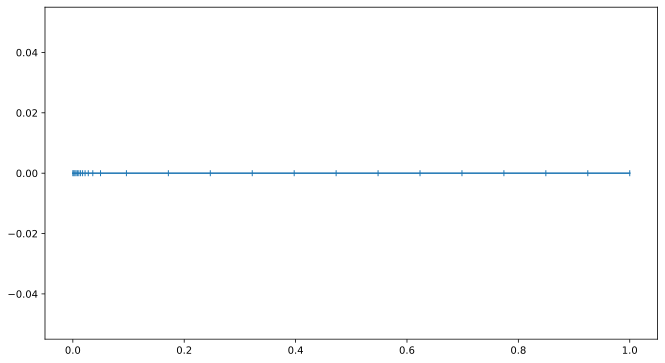

In [13]:
# Create  B mesh x for the initial guess

tau = 0
tauold = -11

sigma = 2
epsilon = 0.01
beta = 1
q = 0.5
layers = 1
N = 24

meps = sigma*epsilon/beta
print(meps)

while tau >= 0 and np.abs(tau - tauold ) > 1*10**(-10):
  tauold = tau
  #print(tau)

  chitau = meps*np.log(q/(q-tau))

  if (layers == 2):
    tau = q - meps*(1 - 2*tau)/(1-2*chitau)
  else:
    tau = q - meps*(1-tau)/(1-chitau)
chitau = meps*np.log(q/(q-tau))

print(tau)
print(chitau)


if chitau < 0.0:
  xB = np.linspace(0,1,N+1)

else:
  xB = np.zeros(N+1)
  if layers == 2:
    i = np.arange(0,N/2)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    print(xB)
    for p in range(k,int(N/2)):
      xB[p] = chitau + (1-2*chitau)/(1 - 2*tau) * ((i[p])/N - tau)
    xB[int(N/2)] = 0.5
    for p in range(int(N/2) + 1, N+1):
      xB[p] = 1 - xB[N-p]
    print(xB)
  else:
    i = np.arange(0,N)
    k = np.searchsorted(i/N, tau)
    for p in range(0,k):
      xB[p] = -meps*np.log(1 - (i[p])/N/q)
    for p in range(k,N):
      xB[p] = chitau + (1-chitau)/(1-tau) * ((i[p])/N-tau)
    xB[N] = 1

yvals = np.linspace(0,1,len(xB))

print()
plt.plot(xB, [0 for i in range(len(xB))], marker = "|")
plt.show()

## The Iteration - Set up to Parameter Test the M That Uses u' '

If you want to use another M you must take the code outside of this triple loop over a,b,c

In [14]:
# the setup
N = 24
epsilon = 0.01
eps = Constant(epsilon)
MPIters = 50
deg = 2 # degree of FEM for physical solve
Bak = True # start on B mesh?
Bak_M = False # B mesh generator
HR_M = False # (5.191)
Grad_M = False # Trying to match Bak_M with u'
Hess_M = False #(5.192)
second_deriv_M = True # u'' based M set up to match the Bak_M  but have solution dependence

# set xi and x
xi_mesh = UnitIntervalMesh(N)
xi = SpatialCoordinate(xi_mesh)
V = FunctionSpace(xi_mesh, "CG", deg)
W = FunctionSpace(xi_mesh, "CG", 1)

results = []


for a_c in [1/4, 1/2, 1, 2]:
  for b_c in [1/4, 1/2, 1, 2]:
    for c_c in [1/4, 1/2, 1, 2]:


      print("a = ", a_c, "b = ", b_c, "c = ", c_c)
      print()


      #  Getting rid of the cases that diverge

      if a_c == 1/4 and b_c == 1/2 and c_c == 1:
        print(" a = 1/4, b = 1/2, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 1/2 and c_c == 2:
        print(" a = 1/4, b = 1/2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 1 and c_c == 1:
        print(" a = 1/4, b = 1, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 2 and c_c == 1/2:
        print(" a = 1/4, b = 2, c = 1/2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 2 and c_c == 1:
        print(" a = 1/4, b = 2, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/2 and b_c == 1 and c_c == 1:
        print(" a = 1/2, b = 1, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/2 and b_c == 2 and c_c == 1/2:
        print(" a = 1/2, b = 2, c = 1/2 skiped b/c mesh solve diverges")
        print()
        continue


      if a_c == 1/2 and b_c == 2 and c_c == 1:
        print(" a = 1/2, b = 2, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 1 and c_c == 1:
        print(" a = 1, b = 1, c = 1 skiped b/c mesh solve diverges")
        print()
        continue


      if a_c == 1 and b_c == 2 and c_c == 1/4:
        print(" a = 1, b = 2, c = 1/4 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 2 and c_c == 1/2:
        print(" a = 1, b = 2, c = 1/2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 2 and c_c == 1:
        print(" a = 1, b = 2, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 1 and c_c == 1/2:
        print(" a = 2, b = 1, c = 1/2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 1 and c_c == 1:
        print(" a = 2, b = 1, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 2 and c_c == 1/4:
        print(" a = 2, b = 2, c = 1/4 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 2 and c_c == 1/2:
        print(" a = 2, b = 2, c = 1/2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 2 and c_c == 1:
        print(" a = 2, b = 2, c = 1 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 1 and c_c == 2:
        print(" a = 1/4, b = 1, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/4 and b_c == 2 and c_c == 2:
        print(" a = 1/4, b = 2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/2 and b_c == 1/2 and c_c == 2:
        print(" a = 1/2, b = 1/2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/2 and b_c == 1 and c_c == 2:
        print(" a = 1/2, b = 1, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1/2 and b_c == 2 and c_c == 2:
        print(" a = 1/2, b = 2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 1/2 and c_c == 2:
        print(" a = 1, b = 1/2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 1 and c_c == 2:
        print(" a = 1, b = 1, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 1 and b_c == 2 and c_c == 2:
        print(" a = 1, b = 2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 1/2 and c_c == 2:
        print(" a = 2, b = 1/2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 1 and c_c == 2:
        print(" a = 2, b = 1, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      if a_c == 2 and b_c == 2 and c_c == 2:
        print(" a = 2, b = 2, c = 2 skiped b/c mesh solve diverges")
        print()
        continue

      x = Function(W)


      if Bak :
        x.dat.data[:] = xB[:]

      else :
        x.interpolate(xi[0])




      for i in range(25): # 3 MP Iters


        # physical solve



        u = TrialFunction(V)
        v = TestFunction(V)
        eps = Constant(epsilon)

        # The rhs

        u_known = cos(pi*x / 2) - ( exp(-x/eps) - exp(-1/eps) ) / (1 - exp(-1/eps) )
        u_prpr = (-pi**2)/4 * cos(pi*x / 2) - ( exp(-x/eps) ) / ( eps**2 * ( 1 - exp(-1/eps)) )
        f = -eps**2 * u_prpr +  u_known

        # J

        J = x.dx(0)
        invJ = 1/J

        # The terms of the weak form

        u_deriv = invJ * grad(u)
        v_deriv = invJ * grad(v)

        term1 = eps**2 * inner(u_deriv, v_deriv)
        term2 = inner(u, v)

        a = (term1 + term2) * J * dx

        L = inner(f, v) * J * dx

        # BC's

        bcs = DirichletBC(V, known_solution(x, epsilon), "on_boundary")

        # Solve the problem

        u_sol = Function(V)
        solve( a == L, u_sol, bcs)



        # The Mesh Density Function


        if HR_M:

          alpha_hat = Constant(1)

          grad_x_sol = invJ * u_sol.dx(0)

          alpha_a = assemble(alpha_hat**2 * ( ((u_sol)**2)* J * dx ))

          alpha_b = assemble(( ( grad_x_sol * grad_x_sol )**(2/3) ) * J * dx )**3

          alpha = max(alpha_a , alpha_b)

          M_a = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol) )**(-1/3)

          M_b = ( 1 + (1/alpha) * (grad_x_sol * grad_x_sol ) )

          M =  M_a * M_b


        if Bak_M:

          K0 = 0.4 # weight of points in layers
          K1 = 0.4
          rho = 0.99  # c >= rho^2
          sigma = 2.5  # sigma > order of FEM + 1

          Mt = K0 * rho * (1/eps) * ( exp( (-rho*x) / (sigma*eps) ) )

          M = 1 + Mt


        if Grad_M:

          grad_x_sol = invJ * u_sol.dx(0)

          # alpha = Constant(2)
          alpha = 0.6325

          M = 1 + alpha * abs( grad_x_sol )


        if Hess_M:

          d = 1
          q = 2
          m = 0
          p = 2
          alpha_hat = 1

          u_pr = u_sol.dx(0)
          u_prpr = u_pr.dx(0)

          p1 = max((d*q) / (d + q*(2-m)) - 1, 0)
          p2 = (m*q - 1)/(d + q*(2-m)) + 1

          alpha_tild = 2 * 2**(p1)
          alpha_t1 = assemble(alpha_hat * ( ((u_sol)**2) * J * dx ))

          alpha = max(alpha_t1, alpha_tild)


          M = (1 + (1/alpha)*abs(u_prpr))**p2


        if second_deriv_M:

          u_pr = (1/J) * u_sol.dx(0)
          u_prpr = (1/J) * u_pr.dx(0)


          M = (1 + (a_c)*abs(u_prpr)**b_c)**c_c



        # Mesh Solve

        # set solution and test function
        new_x = Function(W)
        vm = TestFunction(W)

        # jacobian
        Jm = new_x.dx(0)
        invJm = 1/Jm

        # v'
        # v_pr = (vm).dx(0)
        v_pr = (vm).dx(0)

        # the lhs of the eqn
        F = ( (1/M) * (invJm) * v_pr ) * dx

        # bc's
        bc0 = DirichletBC(W, Constant(0), 1)
        bc1 = DirichletBC(W, Constant(1), 2)
        bcs = [bc0, bc1]


        # initial guess - uniform

        new_x.interpolate(x)


        # solve
        # solve( F == 0, new_x, bcs = bcs, solver_parameters = {'snes_converged_reason': None,\
        #                             'snes_monitor': None, "snes_linesearch_type": "l2",\
        #                              "snes_linesearch_monitor": None} )

        solve( F == 0, new_x, bcs = bcs, solver_parameters = {"snes_linesearch_type": "l2"} )






        # Update x


        x = new_x



      # plots

      # print("CREATING AND SAVING PLOT FOR a,b,c = ", a_c, b_c , c_c)
      # print()
      fig, axes = plt.subplots(1, 2, figsize = (14, 6))
      x_plot = new_x.dat.data
      axes[0].plot(x_plot, [0 for i in range(len(x_plot))], marker = "|")
      axes[0].set_title("current x grid (linear winslow)")
      firedrake.pyplot.mpl.plot(u_sol, label = "Computed u", axes = axes[1])
      firedrake.pyplot.mpl.plot(Function(V).interpolate(known_solution(x, epsilon)), label = "Exact u", axes = axes[1])
      plt.plot(x.dat.data, [0 for i in range(len(x.dat.data))], marker = "|", label = "x mesh", axes = axes[1])
      axes[1].set_title("Comparing the Computed u to the Known u (on the x grid)")
      axes[1].set_xlabel("x")
      axes[1].set_ylabel("u")
      axes[1].legend()
      # if (i == 0 or i == (MPIters - 1)):
      #   pdf_path = '/content/drive/My Drive/Summer_2024_Work/MeshForiequals' + str(i) + '.pdf'
      #   plt.savefig(pdf_path)
      plt.tight_layout()
      plt.close(fig)
      results.append([a_c, b_c, c_c, fig])







a =  0.25 b =  0.25 c =  0.25

a =  0.25 b =  0.25 c =  0.5

a =  0.25 b =  0.25 c =  1

a =  0.25 b =  0.25 c =  2

a =  0.25 b =  0.5 c =  0.25

a =  0.25 b =  0.5 c =  0.5

a =  0.25 b =  0.5 c =  1

 a = 1/4, b = 1/2, c = 1 skiped b/c mesh solve diverges

a =  0.25 b =  0.5 c =  2

 a = 1/4, b = 1/2, c = 2 skiped b/c mesh solve diverges

a =  0.25 b =  1 c =  0.25

a =  0.25 b =  1 c =  0.5

a =  0.25 b =  1 c =  1

 a = 1/4, b = 1, c = 1 skiped b/c mesh solve diverges

a =  0.25 b =  1 c =  2

 a = 1/4, b = 1, c = 2 skiped b/c mesh solve diverges

a =  0.25 b =  2 c =  0.25

a =  0.25 b =  2 c =  0.5

 a = 1/4, b = 2, c = 1/2 skiped b/c mesh solve diverges

a =  0.25 b =  2 c =  1

 a = 1/4, b = 2, c = 1 skiped b/c mesh solve diverges

a =  0.25 b =  2 c =  2

 a = 1/4, b = 2, c = 2 skiped b/c mesh solve diverges

a =  0.5 b =  0.25 c =  0.25

a =  0.5 b =  0.25 c =  0.5

a =  0.5 b =  0.25 c =  1

a =  0.5 b =  0.25 c =  2

a =  0.5 b =  0.5 c =  0.25

a =  0.5 b =  0.5 c =  0.5


a =  0.25 b =  0.25  c =  0.25


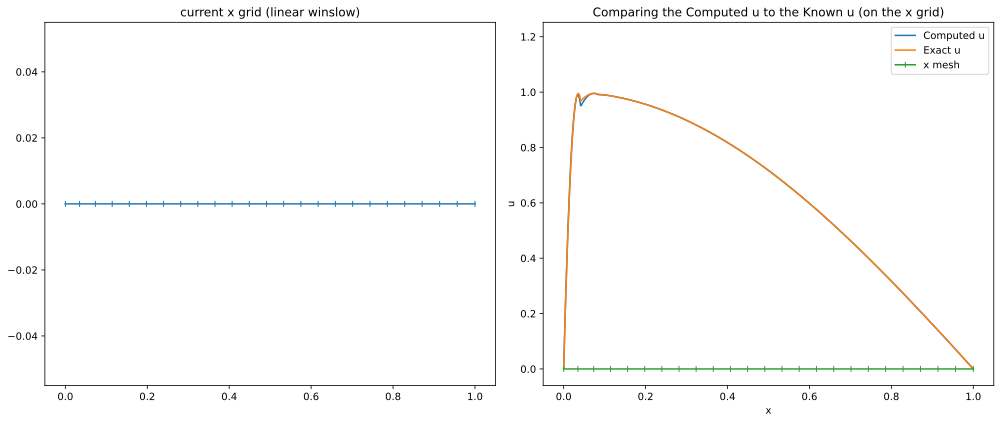



a =  0.25 b =  0.25  c =  0.5


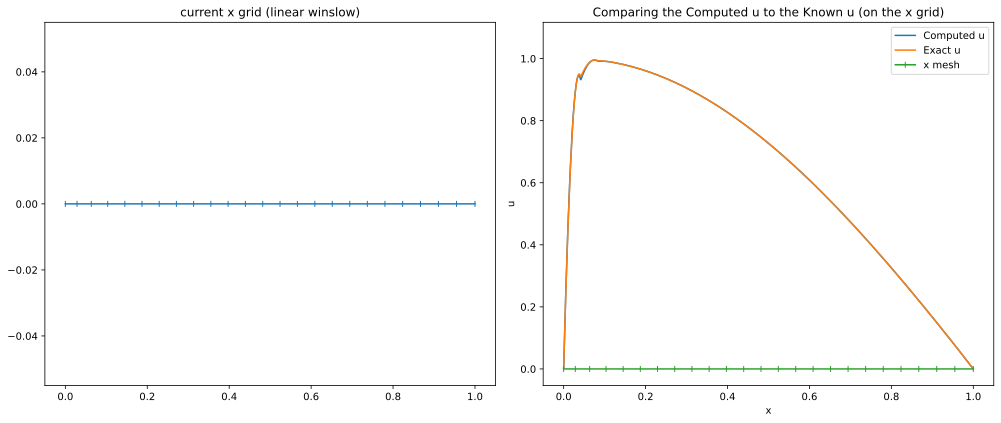



a =  0.25 b =  0.25  c =  1


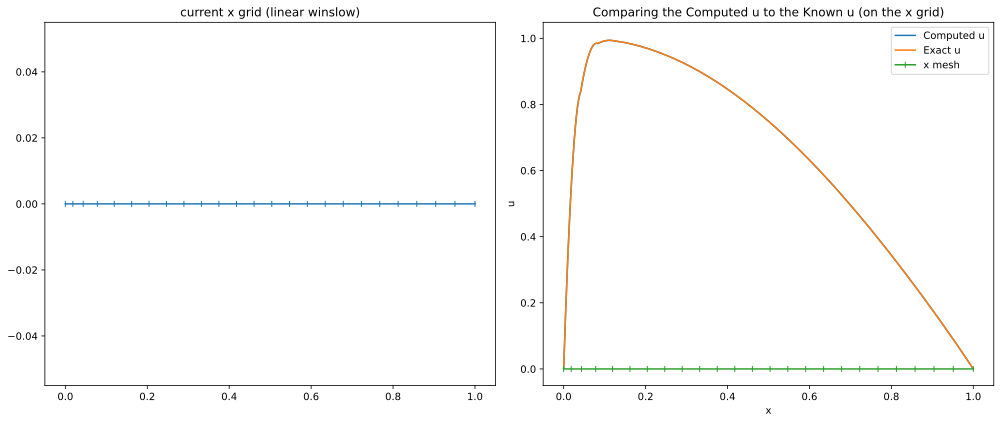



a =  0.25 b =  0.25  c =  2


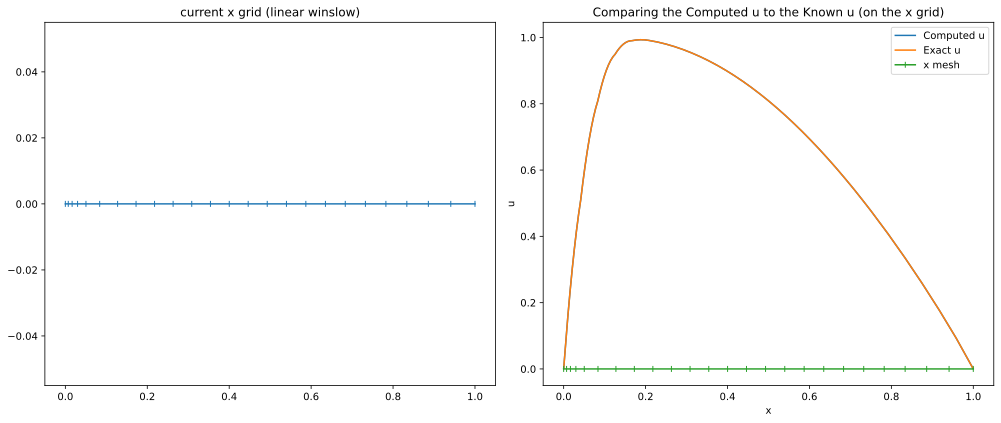



a =  0.25 b =  0.5  c =  0.25


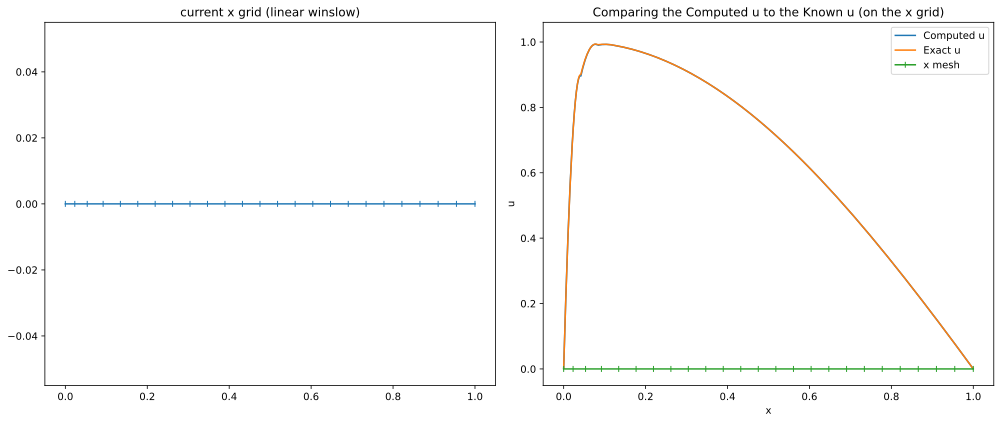



a =  0.25 b =  0.5  c =  0.5


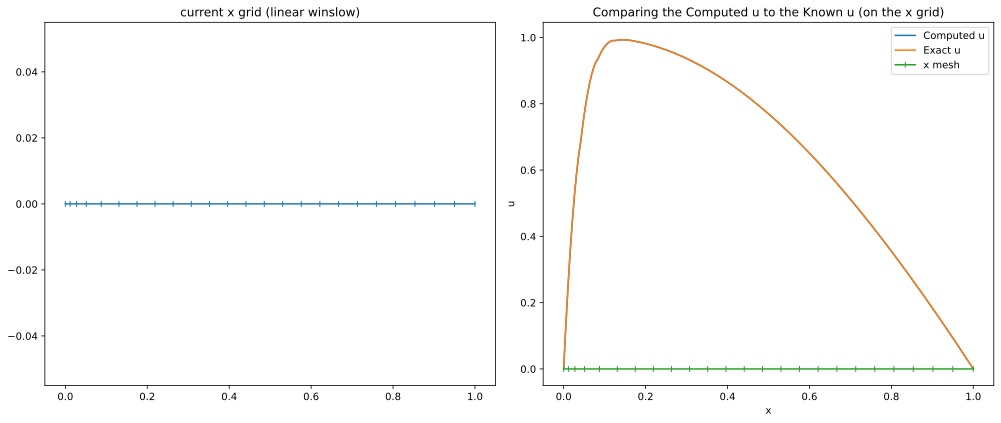



a =  0.25 b =  1  c =  0.25


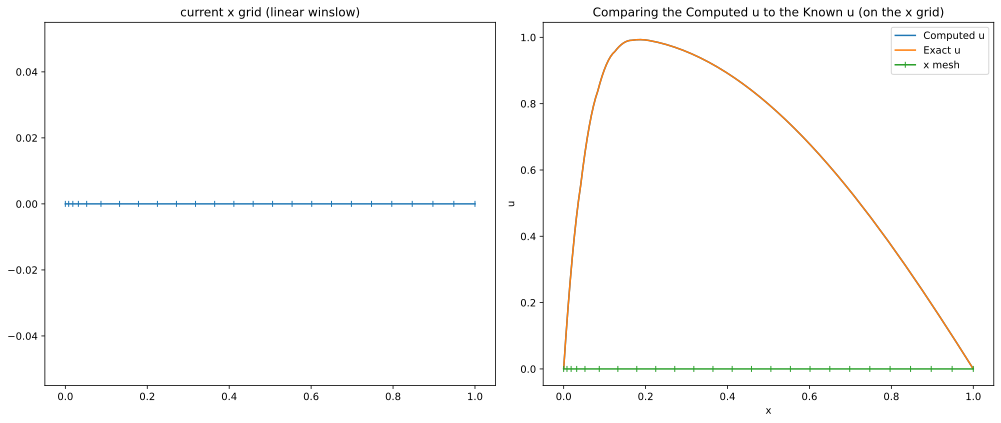



a =  0.25 b =  1  c =  0.5


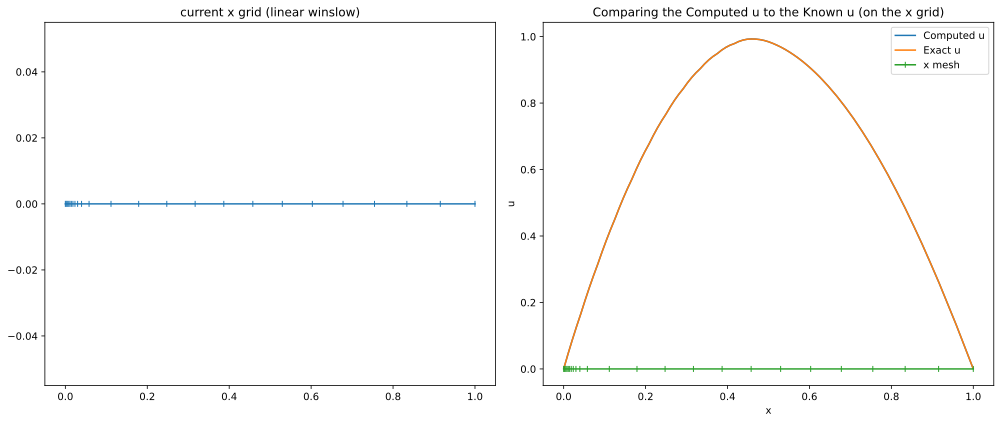



a =  0.25 b =  2  c =  0.25


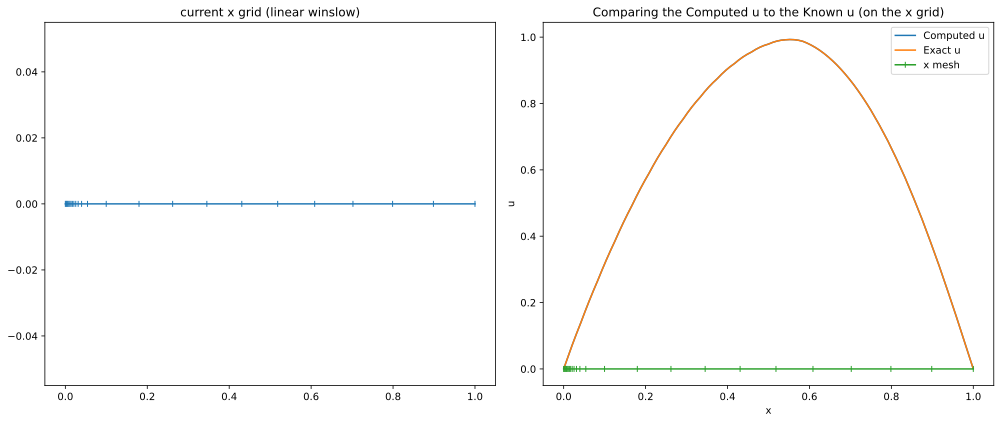



a =  0.5 b =  0.25  c =  0.25


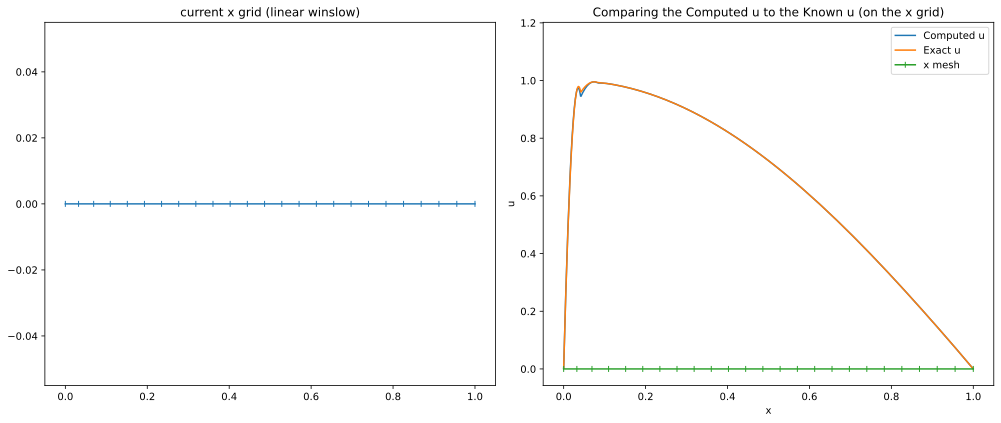



a =  0.5 b =  0.25  c =  0.5


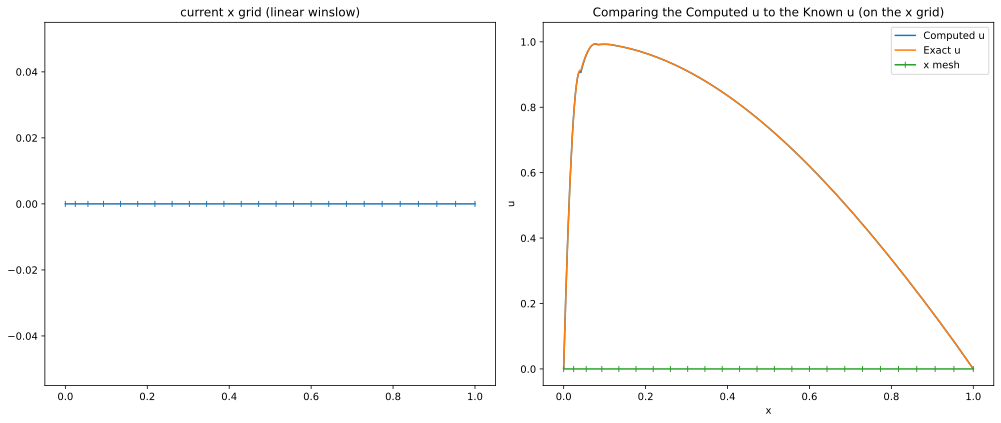



a =  0.5 b =  0.25  c =  1


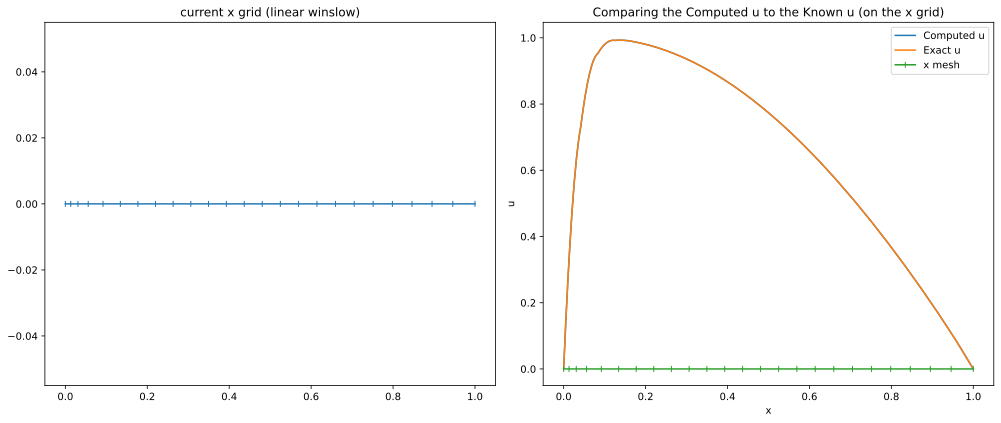



a =  0.5 b =  0.25  c =  2


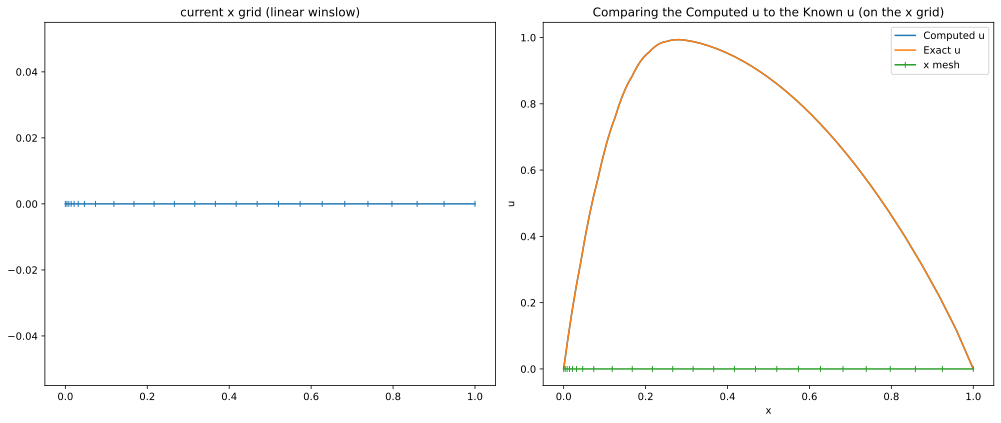



a =  0.5 b =  0.5  c =  0.25


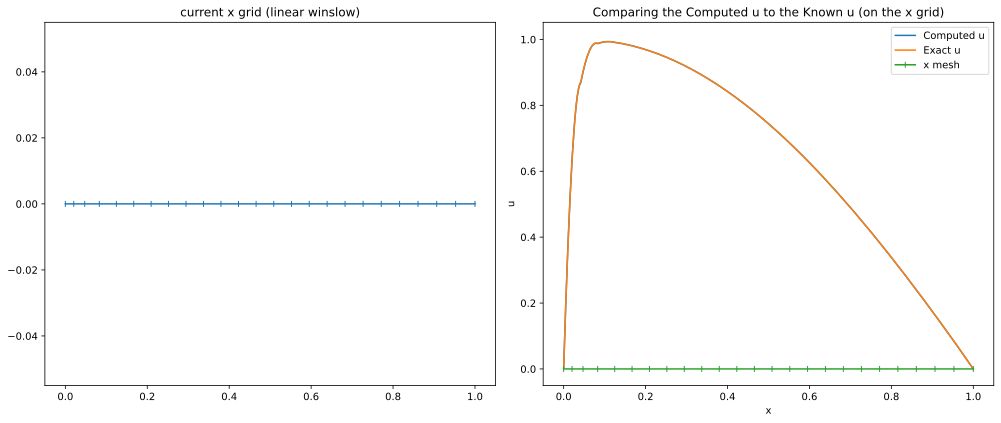



a =  0.5 b =  0.5  c =  0.5


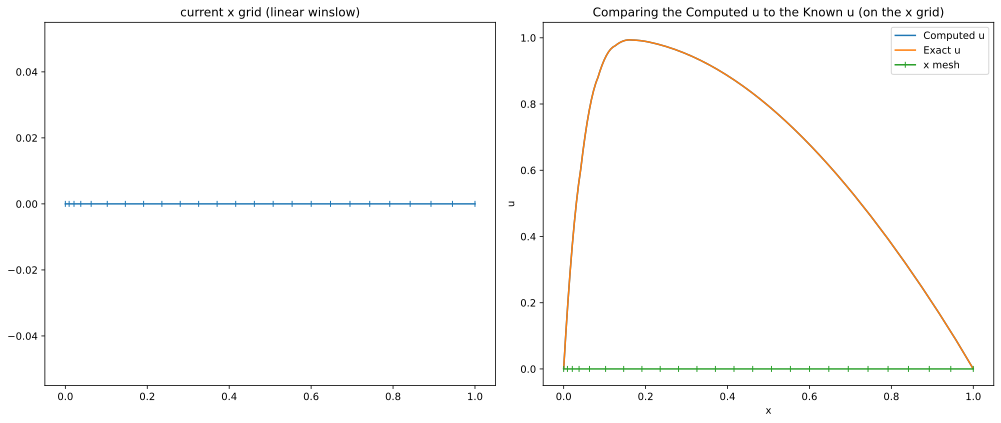



a =  0.5 b =  0.5  c =  1


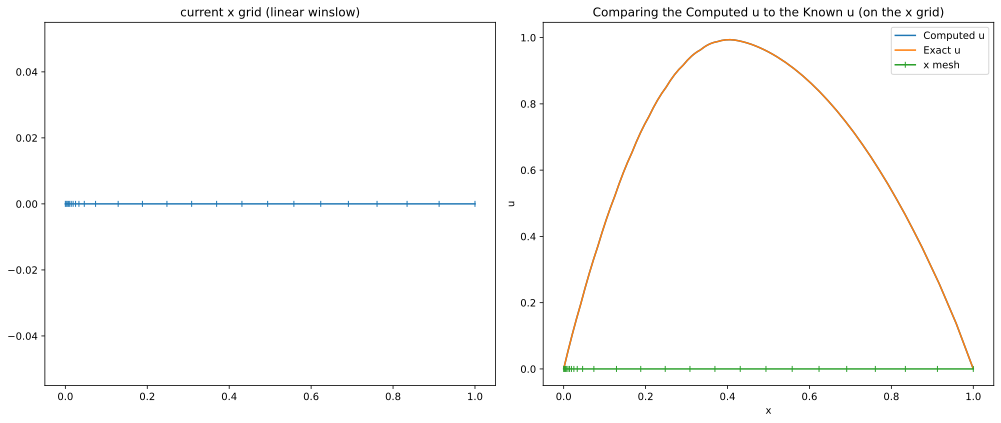



a =  0.5 b =  1  c =  0.25


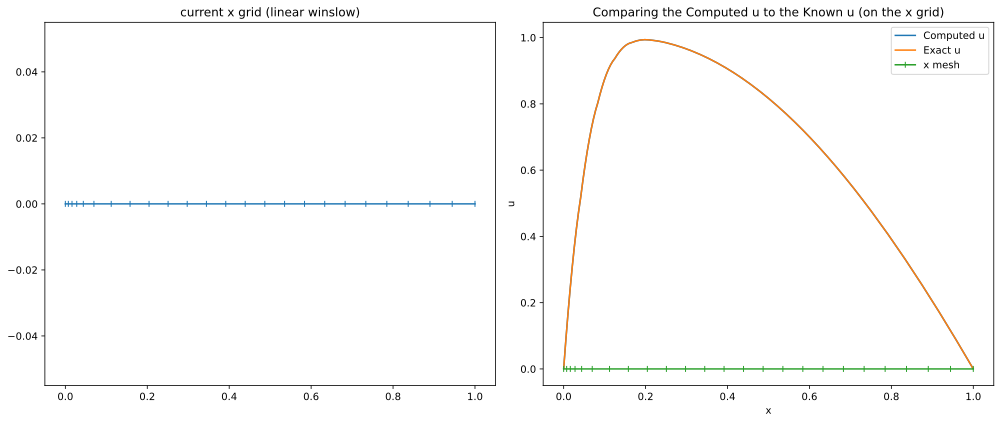



a =  0.5 b =  1  c =  0.5


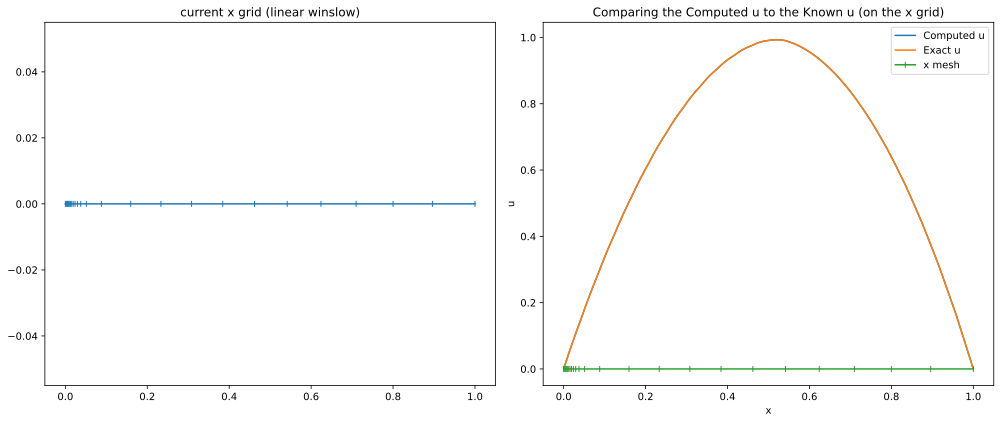



a =  0.5 b =  2  c =  0.25


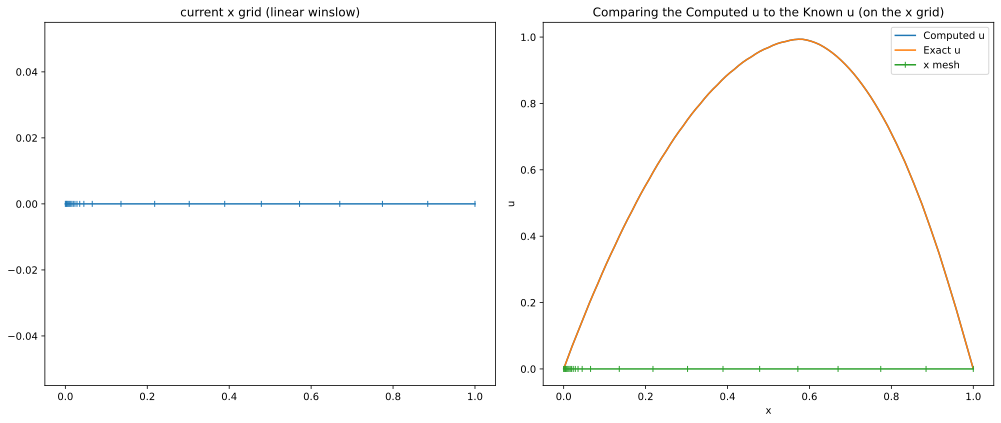



a =  1 b =  0.25  c =  0.25


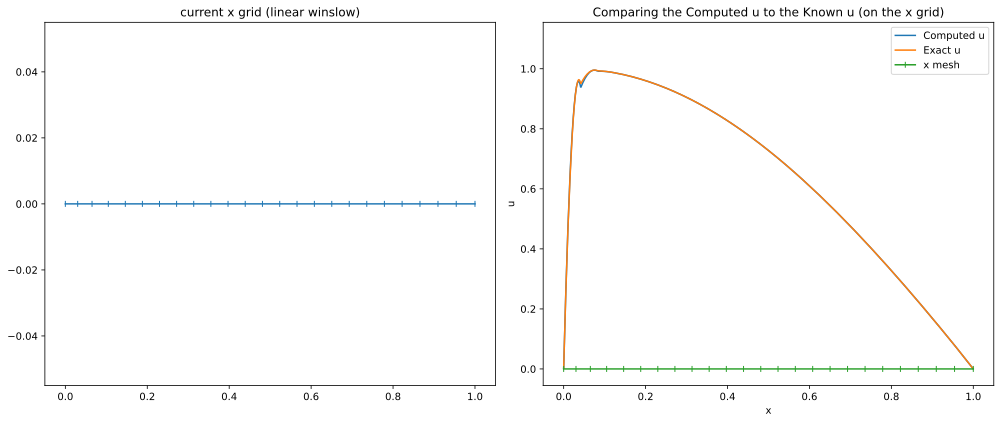



a =  1 b =  0.25  c =  0.5


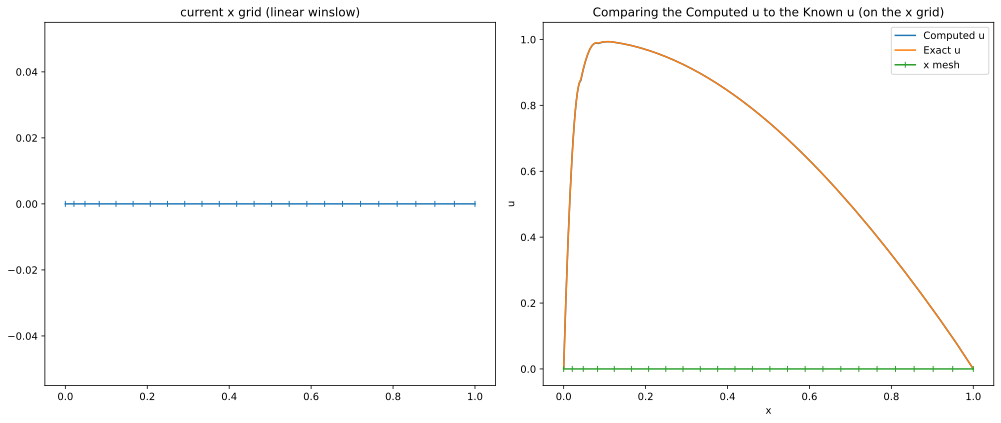



a =  1 b =  0.25  c =  1


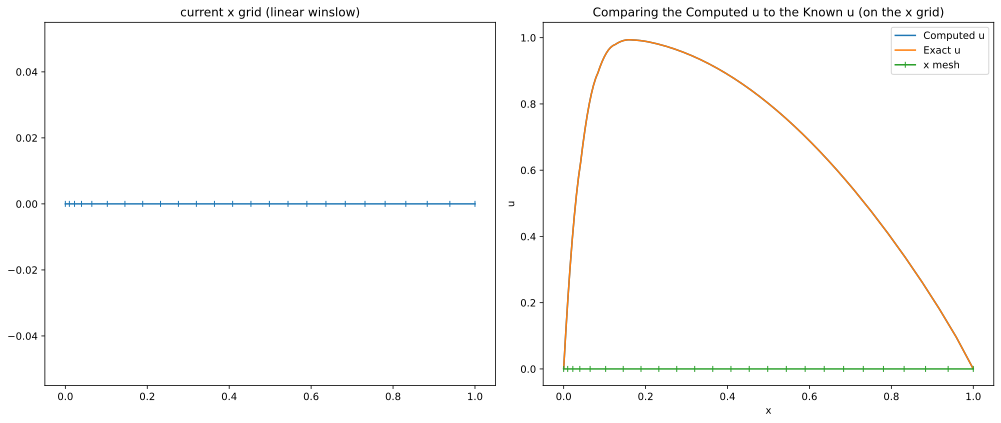



a =  1 b =  0.25  c =  2


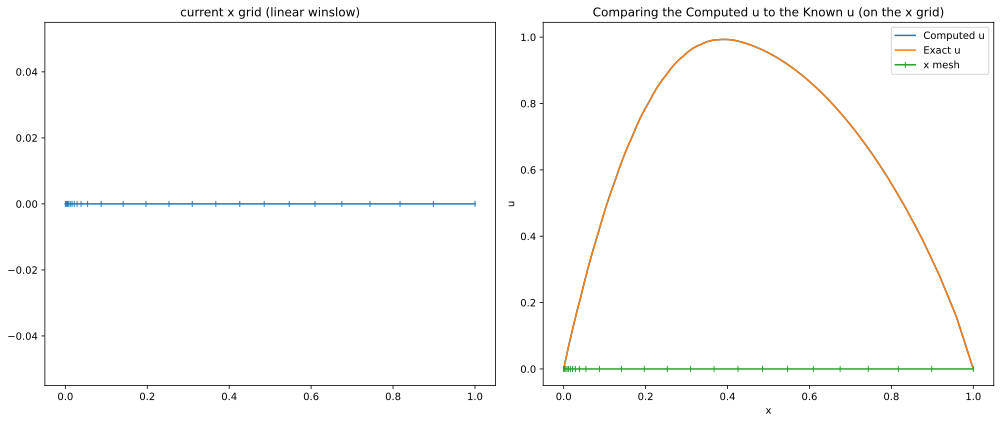



a =  1 b =  0.5  c =  0.25


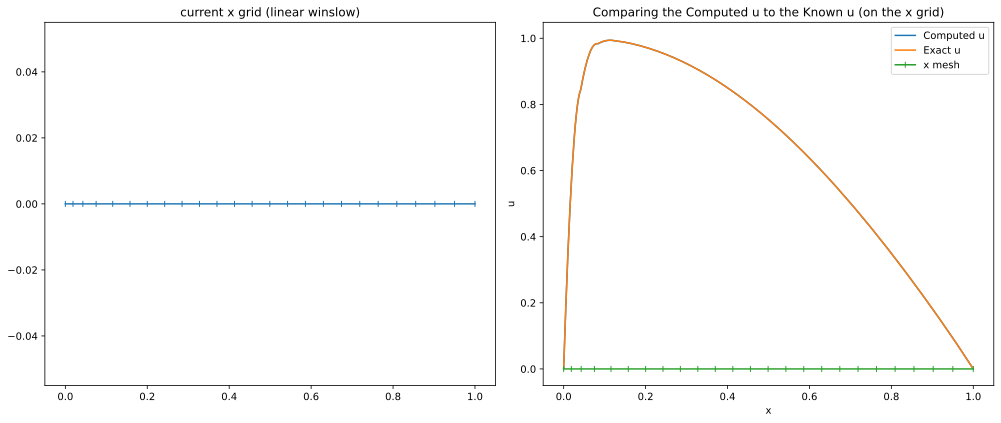



a =  1 b =  0.5  c =  0.5


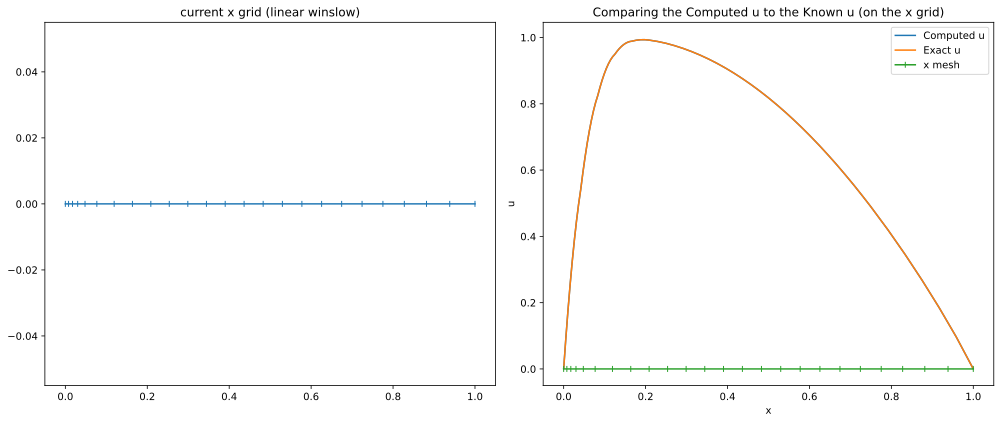



a =  1 b =  0.5  c =  1


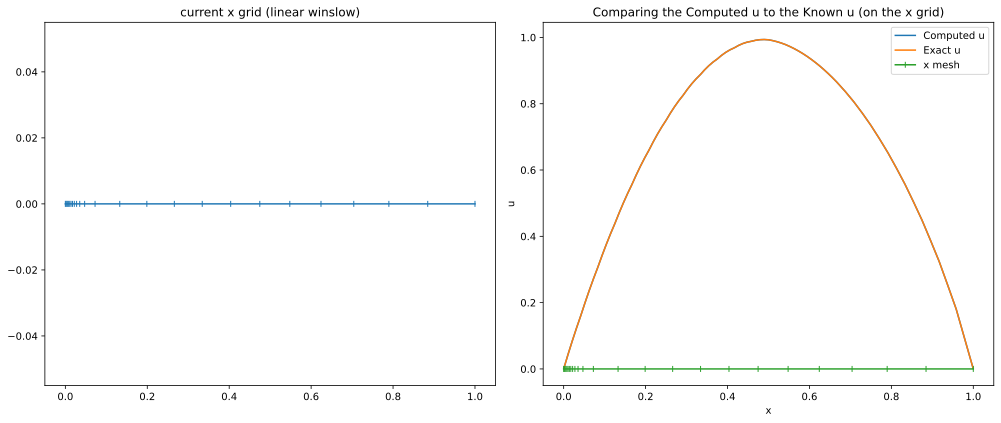



a =  1 b =  1  c =  0.25


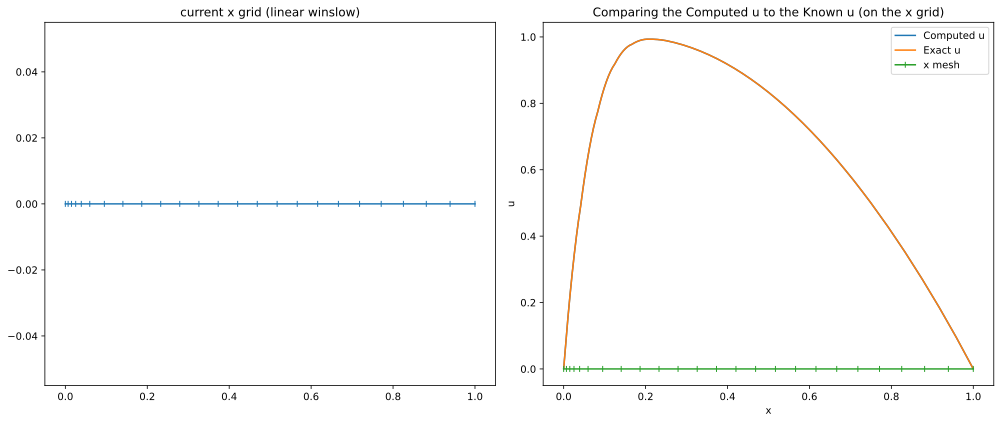



a =  1 b =  1  c =  0.5


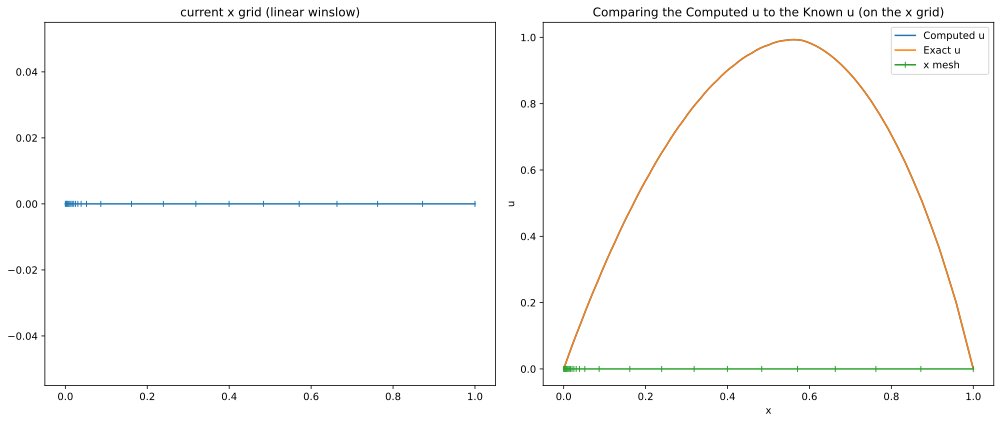



a =  2 b =  0.25  c =  0.25


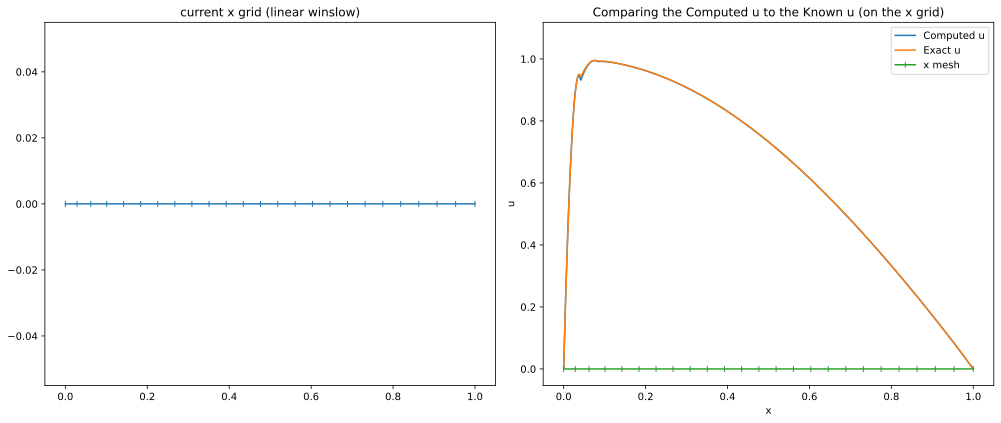



a =  2 b =  0.25  c =  0.5


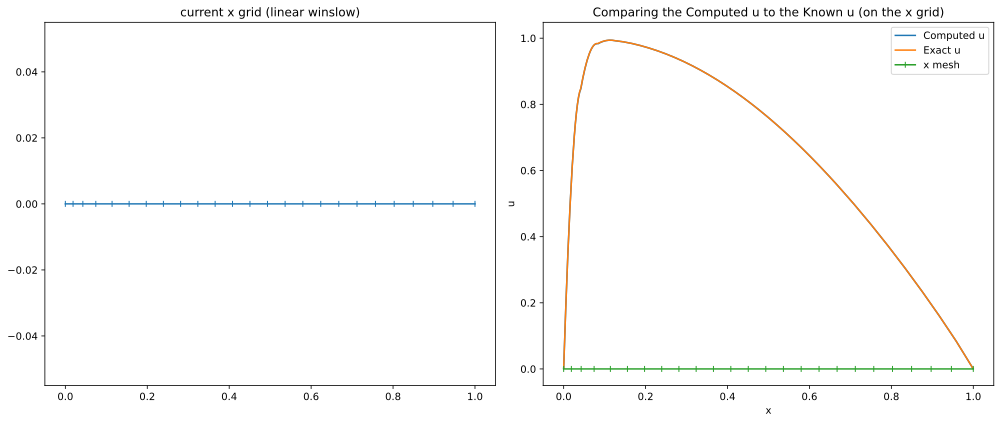



a =  2 b =  0.25  c =  1


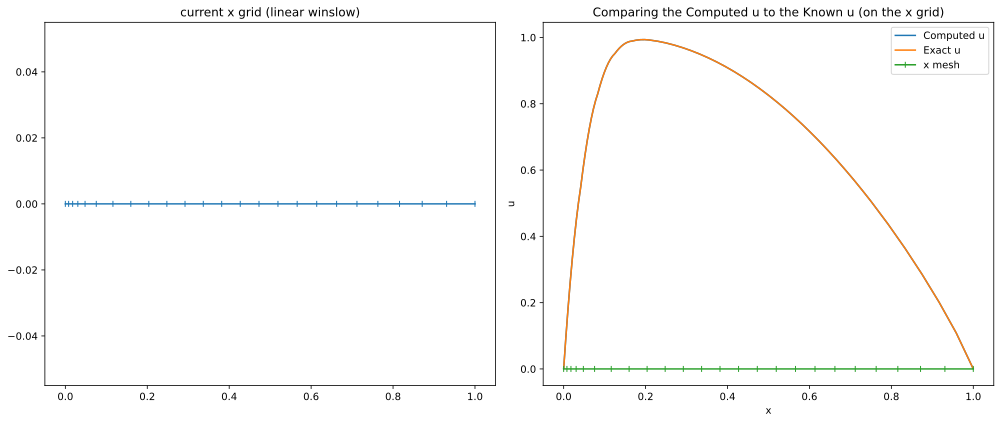



a =  2 b =  0.25  c =  2


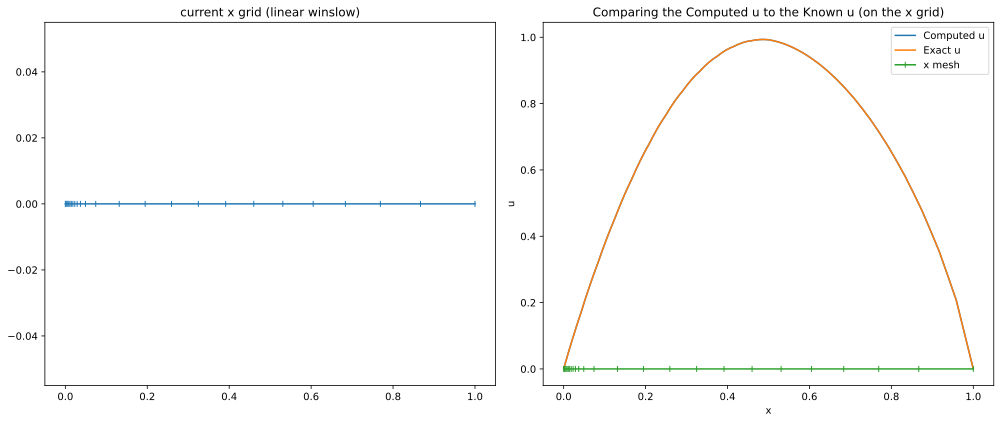



a =  2 b =  0.5  c =  0.25


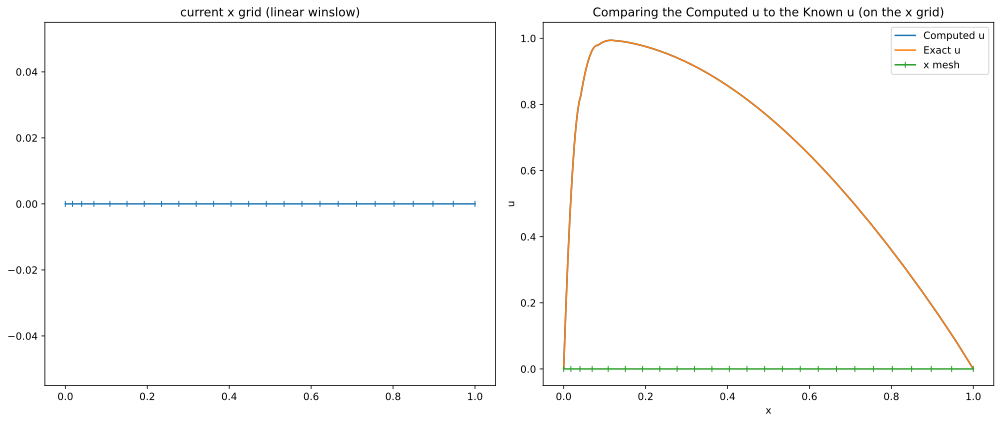



a =  2 b =  0.5  c =  0.5


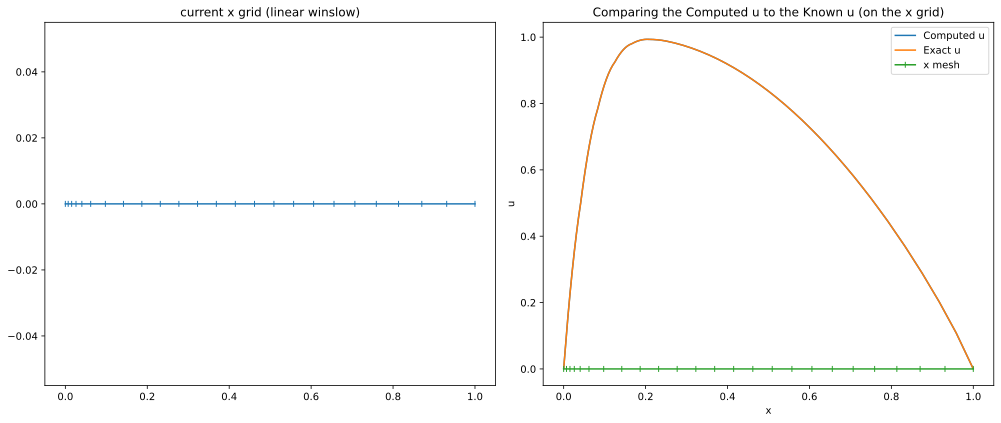



a =  2 b =  0.5  c =  1


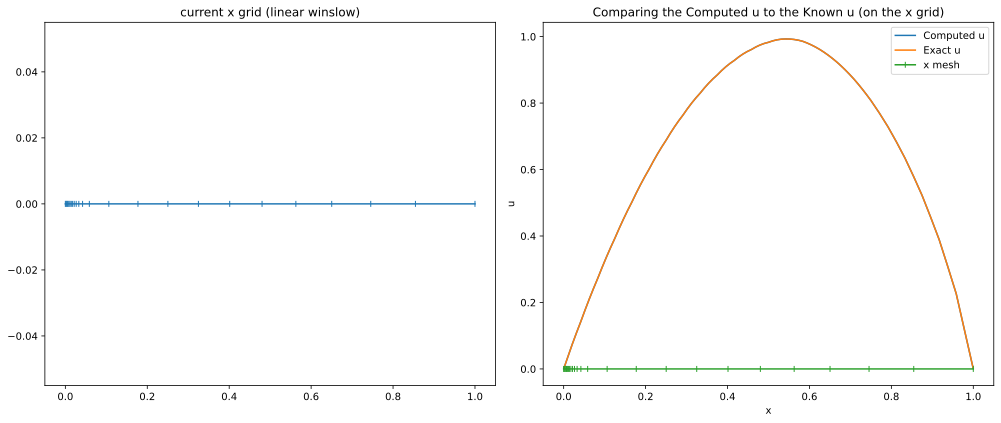



a =  2 b =  1  c =  0.25


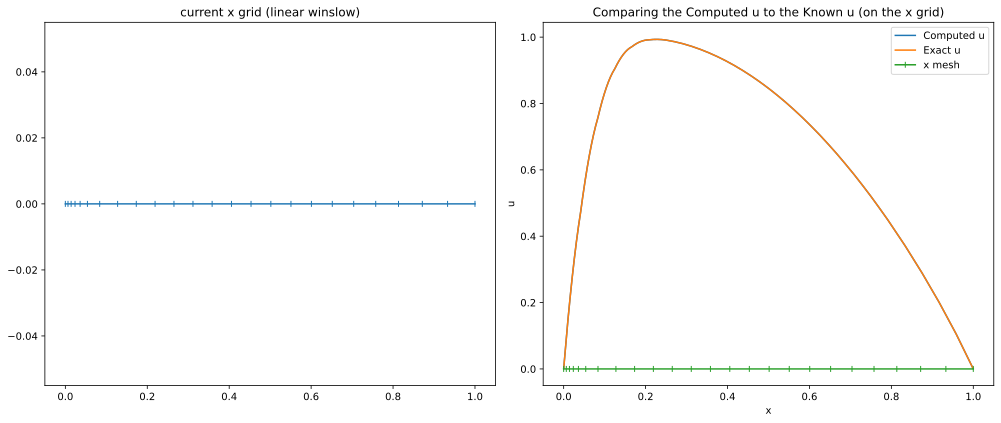

In [15]:
for i in range(len(results)):
  print("a = ", results[i][0], end = " ")
  print("b = ", results[i][1], end = " ")
  print(" c = ", results[i][2])
  display(results[i][3])
  print()
  print()